In [51]:
from astropy.io import fits, ascii
import numpy as np
import matplotlib.pyplot as plt
from utils.common_imports import np, time, plt, fits, Table, new_colors
from utils.io import plot_tgt_done
from astropy.table import Column

In [17]:
'''
Target uploader requirement:
https://pfs-etc.naoj.hawaii.edu/uploader/doc/inputs.html

ob_code, obj_id, obj_type, ra, dec, pmra, pmdec, epoch, exptime, priority, resolution, reference_arm, g_ps1, g_ps1_error
'''

'\nTarget uploader requirement:\nhttps://pfs-etc.naoj.hawaii.edu/uploader/doc/inputs.html\n\nob_code, obj_id, obj_type, ra, dec, pmra, pmdec, epoch, exptime, priority, resolution, reference_arm, g_ps1, g_ps1_error\n'

# function: get the combined data table

In [50]:
def get_combined_table(field, Li, visit, data_cos, data_star, data_sky):
    print(data_cos.colnames)
    print(data_star.colnames)
    print(data_sky.colnames)

    n_cos, n_star, n_sky = len(data_cos), len(data_star), len(data_sky)
    n_tot = n_cos + n_star + n_sky
    print('field %s, %s, visit %d, cosmology--%d, star--%d, sky--%d'%(field, Li, visit, n_cos, n_star, n_sky))

    # necessary columns for the final output
    common_cols = ['ob_code', 'catId', 'description', 'ra', 'dec', 'exptime', 'priority', 'resolution', 'reference_arm']
    common_col_dtype = [np.str_, np.int32, np.str_, np.float32, np.float32, np.float32, np.int32, np.str_, np.str_]

    # create the data table for the final output
    data_table = Table()
    for colname in common_cols[:6]:
        data_table[colname] = np.concatenate((data_cos[colname], data_star[colname], data_sky[colname]))

    for colname, coltype, colval in zip(common_cols[6:], common_col_dtype[6:], [1, 'L', 'r']):
        if coltype == np.str_:
            data_table[colname] = Column([colval] * n_tot, dtype=coltype)
        else:
            data_table[colname] = Column(np.zeros(n_tot, dtype=coltype) + colval)

    # remove the _Star_ prefix and make obj_id dtype = int64
    obj_id_cos = data_cos['obj_id']
    obj_id_sky = np.array(data_sky['obj_id'], dtype=np.int64)
    obj_id_star = np.array([int(x[6:]) for x in data_star['ID']], dtype=np.int64)
    
    data_table['obj_id'] = np.concatenate((obj_id_cos, obj_id_star, obj_id_sky))

    # make sure that obj_id is unique
    assert len(np.unique(data_table['obj_id'])) == n_tot

    # create columns that have different colnames for cosmology, star and sky targets
    cos_cols = ['g_hsc', 'g_hsc_err', 'r2_hsc', 'r2_hsc_err', 'i2_hsc', 'i2_hsc_err', 'z_hsc', 'z_hsc_err', 'y_hsc', 'y_hsc_err']
    nan_star = np.full(n_star, np.nan)
    nan_sky = np.full(n_sky, np.nan)
    nan_cos = np.full(n_cos, np.nan)

    for colname in cos_cols:
        print(colname)
        data_table[colname] = np.concatenate([data_cos[colname], nan_star, nan_sky])

    star_cols = ['epoch', 'input_catalog_id', 'psf_flux_g', 'psf_flux_error_g', \
        'psf_flux_r', 'psf_flux_error_r', 'psf_flux_i', 'psf_flux_error_i', 'psf_flux_z', 'psf_flux_error_z', \
        'psf_flux_y', 'psf_flux_error_y']
    for colname in star_cols:
        print(colname)
        data_table[colname] = np.concatenate([nan_cos, data_star[colname], nan_sky])

    for colname in ['parallax', 'parallax_error']:
        print(colname)
        data_table[colname] = np.concatenate([np.zeros(n_cos)+1e-7, data_star[colname], np.zeros(n_sky)+1e-7])

    for colname in ['pmra', 'pmra_error', 'pmdec', 'pmdec_error']:
        print(colname)
        data_table[colname] = np.concatenate([np.zeros(n_cos), data_star[colname], np.zeros(n_sky)])

    # target_type (int) -- 1 for science, 2 for sky, 3 for flusstd (note target_type_id is defined already in fluxstd targets)
    data_table['target_type'] = np.concatenate([np.ones(n_cos, dtype=np.int32), np.zeros(n_star, dtype=np.int32)+3, np.zeros(n_sky, dtype=np.int32)+2])

    return data_table

# get the target list from netflow output and original cosmology target list

field a, L1, visit 1, cosmology 1760, star 59, sky 400
['ob_code', 'obj_id', 'ra', 'dec', 'exptime', 'priority', 'resolution', 'reference_arm', 'g_hsc', 'g_hsc_err', 'r2_hsc', 'r2_hsc_err', 'i2_hsc', 'i2_hsc_err', 'z_hsc', 'z_hsc_err', 'y_hsc', 'y_hsc_err', 'matched', 'catId', 'description']
['ID', 'ra', 'dec', 'exptime', 'stage', 'epoch', 'parallax', 'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'tract', 'patch', 'target_type_id', 'input_catalog_id', 'psf_mag_g', 'filter_g', 'psf_flux_g', 'psf_flux_error_g', 'filter_r', 'psf_flux_r', 'psf_flux_error_r', 'filter_i', 'psf_flux_i', 'psf_flux_error_i', 'filter_z', 'psf_flux_z', 'psf_flux_error_z', 'filter_y', 'psf_flux_y', 'psf_flux_error_y', 'filter_j', 'psf_flux_j', 'psf_flux_error_j', 'prob_f_star', 'teff_brutus', 'teff_brutus_low', 'teff_brutus_high', 'logg_brutus', 'logg_brutus_low', 'logg_brutus_high', 'teff_gspphot', 'teff_gspphot_lower', 'teff_gspphot_upper', 'is_fstar_gaia', 'version', 'catId', 'ob_code', 'descr

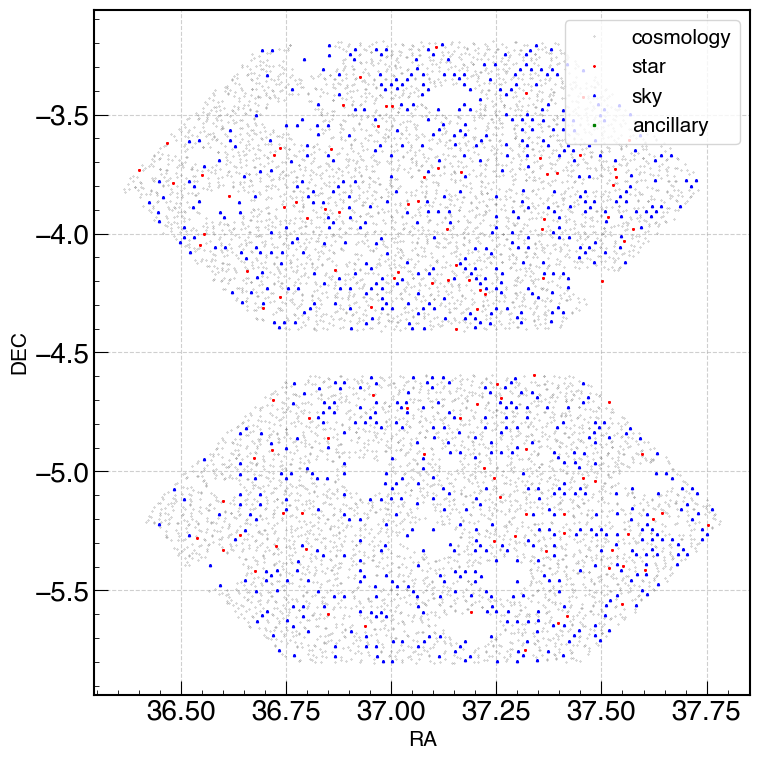

In [21]:
fdir_raw_Jan25 = '../data_raw/Jan25/'
prefix_org = 'cmx_01222025_DESI-ELG_'
outdir_Jan25 = '../output/Jan25_v2/' 
fdir_proc_Jan25 = '../data_proc/Jan25/'

# HST(UTC-10) Jan 22 20:00 for field a and b, same for both visits, Jan 23 01:00 for field e
otime_list = ['2025-01-23T06:00:00Z', '2025-01-23T06:00:00Z', '2025-01-23T09:00:00Z']

#for field, Li_list, otime in zip(['a', 'b', 'e'], [['L1', 'L3', 'L4'], ['L1', 'L2', 'L3'], ['L1', 'L2', 'L3', 'L4']], otime_list):
for field, Li_list, otime in zip(['a', ], [['L1', 'L3'], ], ['2025-01-23T06:00:00Z', ]):
    infn_list = [] # for each filed, including all Li and all visits
    # read original cosmology targets
    data_cos = ascii.read(fdir_raw_Jan25 + prefix_org + 'field-{}_v{}.csv'.format(field, 1))
    # read processed star targets
    data_star = ascii.read(fdir_proc_Jan25 + 'star_field_{}_targets.ecsv'.format(field))
    # read processed sky targets
    data_sky = ascii.read(fdir_proc_Jan25 + 'sky_field_{}_targets.ecsv'.format(field)) 

    # make 'epoch' of data_star to be 2016.
    data_star['epoch'] = np.zeros(len(data_star), dtype=np.float32) + 2016.

    # ob_code
    data_cos['ob_code'] = ['_Cos_'+str(x) for x in data_cos['obj_id']]
    data_star.add_column(data_star['ID'], name='ob_code')
    data_sky.add_column(data_sky['ID'], name='ob_code') #note that 'ID' is sky_id 

    # add catId to the cosmology targets with the value of 11 - HSC-SSP Public Data Release 4 (Wide)
    data_cos.add_column(np.ones(len(data_cos), dtype=np.int32) * 10090, name='catId')
    data_cos.add_column(['HSC-SSP Public Data Release 4 (Wide)'] * len(data_cos), name='description')

    # add 'description' column to sky and star
    data_sky.add_column(['Sky positions from PS1'] * len(data_sky), name='description')
    data_star.add_column(['Fstar_v3.3'] * len(data_star), name='description')

    # change the 'catId' value of star and sky targets 
    data_sky['catId'] = np.zeros(len(data_sky), dtype=np.int32) + 2007
    data_star['catId'] = np.zeros(len(data_star) , dtype=np.int32) + 3006

    # rename 'R.A.', 'Dec.' to 'ra', 'dec' for the processed star and sky targets
    for old_name, new_name in zip(['R.A.', 'Dec.', 'Exposure Time'], ['ra', 'dec', 'exptime']):
        data_star.rename_column(old_name, new_name)
        data_sky.rename_column(old_name, new_name)

    # read netflow output
    for Li in Li_list:
        for visit in [1, 2]:
            infn = outdir_Jan25 + 'field_%s_%s_visit%d.txt'%(field, Li, visit)
            infn_list.append(infn)
        
            tgt_id_done = np.loadtxt(infn, usecols=(0, ), unpack=True, dtype='str')
            # match the tgt_id_done cosmology with the original cosmology targets
            obj_id_cos = np.array(['_Cos_'+str(x) for x in data_cos['obj_id']]) # it's 'ob_code'
            mask_cos = np.in1d(obj_id_cos, tgt_id_done) 
            
            # match the tgt_id_done star with the processed star targets
            mask_star = np.in1d(data_star['ob_code'], tgt_id_done) 

            # match the tgt_id_done sky with the processed sky targets
            mask_sky = np.in1d(data_sky['ob_code'], tgt_id_done)
            
            print('field %s, %s, visit %d, cosmology %d, star %d, sky %d'%(field, Li, visit, np.sum(mask_cos), np.sum(mask_star), np.sum(mask_sky)))
            
            data_table = get_combined_table(field, Li, visit, data_cos[mask_cos], data_star[mask_star], data_sky[mask_sky])
            
            # write the final output to a file
            outfn = outdir_Jan25 + '/final/field_%s_%s_visit%d_final_targets.ecsv'%(field, Li, visit)
            data_table.write(outfn, format='ascii.ecsv', overwrite=True)
            print('write to %s'%outfn)
            
    figname = outdir_Jan25+'/final/fiberassign_'+field+'_done.png'
    plot_tgt_done(infn_list, figname, figsize=(8, 8), plot_diffcolor=True)

# re write the output into format for netflow run

In [15]:
outdir_Jan25 = '../output/Jan25/' 
                        
# HST(UTC-10) Jan 22 20:00 for field a and b, same for both visits, Jan 23 01:00 for field e
otime_list = ['2025-01-23T06:00:00Z', '2025-01-23T06:00:00Z', '2025-01-23T09:00:00Z']

for field, Li_list, otime in zip(['a', 'b', 'e'], [['L1', 'L3', 'L4'], ['L1', 'L2', 'L3'], ['L1', 'L2', 'L3', 'L4']], otime_list):
#for field, Li_list, otime in zip(['a', ], [['L1', 'L3', 'L4'], ], ['2025-01-23T06:00:00Z', ]):
    for Li in Li_list:
        for visit in [1, 2]:
            # read final target list including cosmology, star and sky targets
            data_final = ascii.read(outdir_Jan25 + '/final/field_{}_{}_visit{}_final_targets.ecsv'.format(field, Li, visit))

            # rename 'ra', 'dec' 
            for old_name, new_name in zip(['ra', 'dec', 'exptime', 'obj_id', 'priority'], ['R.A.', 'Dec.', 'Exposure Time', 'ID', 'Priority']):
                data_final.rename_column(old_name, new_name)
                                                       
            n_tgt = len(data_final)
            print('field %s, %s, visit %d, cosmology + star + sky %d'%(field, Li, visit, n_tgt))

            data_final['stage'] = np.zeros(n_tgt, dtype='int32') # 0 for non-ancillary targets

            # print column names and data types if field = 'a' and Li = 'L1', visit = 1
            if field == 'a' and Li == 'L1' and visit == 1: 
                for colname in data_final.colnames:
                    print(colname, data_final[colname].dtype)
            
            # write the final output to a file
            outfn = outdir_Jan25 + '/final_nf_input/field_%s_%s_visit%d_final_targets.ecsv'%(field, Li, visit)
            data_final.write(outfn, format='ascii.ecsv', overwrite=True)
            print('write to %s'%outfn)

field a, L1, visit 1, cosmology + star + sky 2225
ob_code <U25
catId int32
description <U36
R.A. float64
Dec. float64
Exposure Time float64
Priority int32
resolution <U1
reference_arm <U1
ID int64
g_hsc float64
g_hsc_err float64
r2_hsc float64
r2_hsc_err float64
i2_hsc float64
i2_hsc_err float64
z_hsc float64
z_hsc_err float64
y_hsc float64
y_hsc_err float64
epoch float64
input_catalog_id float64
psf_flux_g float64
psf_flux_error_g float64
psf_flux_r float64
psf_flux_error_r float64
psf_flux_i float64
psf_flux_error_i float64
psf_flux_z float64
psf_flux_error_z float64
psf_flux_y float64
psf_flux_error_y float64
parallax float64
parallax_error float64
pmra float64
pmra_error float64
pmdec float64
pmdec_error float64
target_type int32
stage int32
write to ../output/Jan25//final_nf_input/field_a_L1_visit1_final_targets.ecsv
field a, L1, visit 2, cosmology + star + sky 2100
write to ../output/Jan25//final_nf_input/field_a_L1_visit2_final_targets.ecsv
field a, L3, visit 1, cosmology + star

# check the netflow output target list and the pfsDesign file

In [65]:
noncon_field_a_L1_visit1 = [  30,   41,   49,   53,  120,  124,  194,  269,  286,  379,  436,
          455,  485,  528,  549,  597,  649,  657,  682,  703,  706,  708,
          729,  732,  734,  745,  753,  782,  863,  873,  903,  935,  943,
          944,  953,  962,  996, 1043, 1050, 1058, 1086, 1088, 1089, 1119,
         1152, 1174, 1185, 1194, 1364, 1379, 1401, 1470, 1495, 1506, 1522,
         1544, 1576, 1577, 1578, 1579, 1584, 1589, 1592, 1594, 1595, 1600,
         1602, 1603, 1605, 1663, 1721, 1736, 1768, 1779, 1803, 1821, 1921,
         1946, 1972, 2004, 2011, 2032, 2050, 2053, 2065, 2108, 2110, 2128,
         2157, 2184, 2186, 2200, 2234, 2246, 2248, 2249, 2295, 2304, 2345,
         2437, 2456, 2497, 2505, 2518, 2521, 2595, 2597]

noncon_field_a_L1_visit2 = [   7,   28,   30,   49,   53,   66,  104,  165,  197,  227,  348,
          379,  389,  431,  484,  508,  532,  557,  566,  593,  597,  622,
          630,  633,  646,  687,  703,  705,  729,  734,  745,  753,  764,
          800,  843,  873,  896,  925,  949,  956,  989, 1013, 1023, 1043,
         1048, 1050, 1069, 1082, 1086, 1149, 1152, 1267, 1273, 1324, 1401,
         1426, 1428, 1470, 1495, 1500, 1509, 1576, 1577, 1578, 1579, 1584,
         1589, 1592, 1594, 1595, 1597, 1600, 1601, 1602, 1603, 1605, 1690,
         1736, 1770, 1786, 1793, 1821, 1937, 1939, 1972, 2004, 2026, 2053,
         2065, 2098, 2140, 2175, 2184, 2200, 2229, 2230, 2237, 2246, 2252,
         2304, 2332, 2345, 2406, 2458, 2474, 2585]

noncon_field_b_L1_visit1 = [  28,   39,   49,   66,   82,  106,  120,  124,  153,  162,  165,
          196,  197,  227,  243,  284,  287,  311,  390,  422,  431,  451,
          590,  656,  671,  678,  719,  732,  739,  745,  753,  832,  839,
          845,  848,  903,  908,  910,  913,  920,  922,  944,  949,  956,
          961,  965, 1058, 1086, 1104, 1129, 1185, 1296, 1335, 1383, 1436,
         1459, 1492, 1500, 1509, 1576, 1577, 1578, 1579, 1581, 1582, 1584,
         1589, 1592, 1594, 1595, 1597, 1600, 1602, 1603, 1608, 1610, 1646,
         1677, 1683, 1743, 1754, 1768, 1790, 1816, 1826, 1829, 1850, 1873,
         1899, 1972, 2015, 2179, 2184, 2229, 2231, 2246, 2255, 2257, 2295,
         2332, 2345, 2388, 2472, 2474, 2476, 2479, 2485, 2489, 2519, 2520,
         2529, 2532, 2533, 2549, 2577, 2579, 2587, 2599]

noncon_field_b_L1_visit2 = [  31,   72,   82,  106,  120,  170,  196,  254,  287,  308,  310,
          348,  377,  378,  422,  431,  451,  506,  508,  522,  524,  586,
          590,  622,  634,  640,  655,  656,  703,  719,  732,  734,  745,
          753,  800,  806,  839,  843,  876,  878,  891,  910,  913,  920,
          925,  956, 1058, 1075, 1082, 1083, 1119, 1152, 1197, 1304, 1364,
         1379, 1450, 1455, 1459, 1576, 1577, 1578, 1579, 1581, 1584, 1589,
         1592, 1594, 1595, 1597, 1599, 1600, 1603, 1608, 1610, 1677, 1699,
         1710, 1768, 1775, 1821, 1874, 1899, 1919, 1921, 1961, 1963, 1972,
         2020, 2023, 2086, 2115, 2157, 2237, 2244, 2255, 2295, 2312, 2331,
         2332, 2337, 2382, 2391, 2474, 2480, 2485, 2489, 2519, 2521, 2532,
         2533, 2542, 2549, 2559, 2579]

noncon_field_e_L1_visit1 = [   8,   30,   49,   53,   66,  139,  151,  166,  221,  225,  245,
          248,  391,  421,  432,  455,  466,  508,  568,  605,  725,  732,
          734,  825,  874,  885,  896,  910,  913,  916,  942,  944,  949,
          954,  956,  959, 1020, 1035, 1043, 1050, 1058, 1086, 1152, 1183,
         1218, 1239, 1248, 1326, 1338, 1353, 1368, 1370, 1379, 1384, 1431,
         1443, 1535, 1568, 1576, 1577, 1578, 1579, 1584, 1589, 1592, 1594,
         1595, 1600, 1603, 1652, 1657, 1663, 1673, 1675, 1683, 1688, 1715,
         1721, 1732, 1740, 1768, 1771, 1775, 1790, 1800, 1826, 1896, 1931,
         2001, 2013, 2014, 2030, 2128, 2154, 2184, 2201, 2236, 2246, 2262,
         2266, 2311, 2324, 2345, 2367, 2370, 2437, 2441, 2472, 2474, 2476,
         2480, 2515, 2540, 2579, 2595, 2602]

noncon_field_e_L1_visit2 = [  13,   19,   28,   49,   53,   74,  109,  138,  139,  151,  198,
          221,  227,  245,  248,  276,  288,  338,  360,  363,  373,  379,
          411,  422,  436,  438,  442,  484,  489,  508,  591,  592,  605,
          634,  641,  649,  663,  678,  703,  734,  753,  885,  892,  900,
          910,  912,  913,  956,  958,  959,  964, 1001, 1020, 1043, 1050,
         1053, 1058, 1089, 1119, 1152, 1168, 1169, 1183, 1204, 1218, 1226,
         1239, 1273, 1293, 1319, 1326, 1348, 1443, 1445, 1527, 1535, 1576,
         1577, 1578, 1579, 1584, 1589, 1592, 1594, 1595, 1600, 1601, 1603,
         1608, 1663, 1683, 1721, 1743, 1756, 1768, 1771, 1775, 1779, 1810,
         1821, 1849, 1850, 1872, 1926, 1939, 1950, 1999, 2012, 2026, 2030,
         2069, 2083, 2085, 2105, 2124, 2131, 2184, 2203, 2246, 2249, 2266,
         2303, 2332, 2345, 2369, 2375, 2377, 2430, 2434, 2444, 2458, 2480,
         2515, 2565, 2595, 2598, 2600, 2602]

noncon_field_e_L2_visit1 = [  61,   74,  143,  156,  197,  198,  220,  254,  259,  430,  442,
          451,  489,  490,  513,  517,  532,  597,  631,  643,  653,  674,
          745,  747,  753,  789,  832,  841,  845,  861,  903,  911,  920,
          925,  949,  962,  965, 1043, 1050, 1058, 1071, 1089, 1159, 1178,
         1185, 1213, 1218, 1227, 1269, 1332, 1353, 1379, 1383, 1396, 1409,
         1421, 1424, 1426, 1453, 1470, 1494, 1509, 1576, 1577, 1578, 1579,
         1584, 1589, 1592, 1594, 1595, 1597, 1598, 1600, 1603, 1608, 1683,
         1696, 1697, 1768, 1850, 1902, 1925, 1932, 1939, 2047, 2070, 2157,
         2179, 2184, 2212, 2228, 2229, 2237, 2293, 2332, 2340, 2345, 2367,
         2369, 2435, 2479, 2516, 2518, 2522, 2540, 2550, 2555, 2595]

noncon_fiberid_list = [noncon_field_a_L1_visit1, noncon_field_a_L1_visit2, noncon_field_b_L1_visit1, noncon_field_b_L1_visit2, noncon_field_e_L1_visit1, noncon_field_e_L1_visit2, noncon_field_e_L2_visit1]

In [52]:
# read the all the fits files one by one from /Users/jing/My_Work/Ongoing/PFS_CO_Repo/pfs_co_fa/data_raw/Jan25/pfsDesign_cosWG/
fdir_pfsDesign_Jan25 = '../data_raw/Jan25/pfsDesign_cosWG/'

a_L1_visit1 = fits.open(fdir_pfsDesign_Jan25 + 'pfsDesign-0x1e8cb805c5c6f68c.fits')
a_L1_visit2 = fits.open(fdir_pfsDesign_Jan25 + 'pfsDesign-0x23d173cca1fbbeab.fits')
b_L1_visit1 = fits.open(fdir_pfsDesign_Jan25 + 'pfsDesign-0x789072336714f268.fits')
b_L1_visit2 = fits.open(fdir_pfsDesign_Jan25 + 'pfsDesign-0x1a9ee49892a873fa.fits')
e_L1_visit1 = fits.open(fdir_pfsDesign_Jan25 + 'pfsDesign-0x44dd92b4e2b4c3ec.fits')
e_L1_visit2 = fits.open(fdir_pfsDesign_Jan25 + 'pfsDesign-0x7a3320c7520a5f32.fits')
e_L2_visit1 = fits.open(fdir_pfsDesign_Jan25 + 'pfsDesign-0x1a8ae2dab6e685ec.fits')

Jan25_obs_list = [a_L1_visit1, a_L1_visit2, b_L1_visit1, b_L1_visit2, e_L1_visit1, e_L1_visit2, e_L2_visit1]

In [53]:
fdir_obs_Jan25 = '../data_raw/Jan25/' 
objid_obs_Jan25 = np.load(fdir_obs_Jan25 + 'objIds_Run20', allow_pickle=True) #note that here cosmology targets only


In [67]:
outdir_Jan25 = '../output/Jan25/' 
i = 0
for field, Li_list in zip(['a', 'b', 'e'], [['L1', ], ['L1', ], ['L1', 'L2', ]]):
   for Li in Li_list:
        for visit in [1, 2]:
            if(field == 'e' and Li == 'L2' and visit == 2):
                continue
            
            pfs_design = Jan25_obs_list[i]
            noncon_fiberid = noncon_fiberid_list[i]

            # read final target list including cosmology, star and sky targets
            data_final = ascii.read(outdir_Jan25 + '/final/field_{}_{}_visit{}_final_targets.ecsv'.format(field, Li, visit))                                    
            n_tgt = len(data_final)

            # obj_id in pfsdesign file
            mask_in_pfsdesign = np.in1d(data_final['obj_id'], pfs_design[1].data['objId'])
            print('field %s, %s, visit %d: \n%d cosmology + fluxstd + sky: %d in pfsDesign, frac=%.2f, diff=%d.'%(field, Li, visit, n_tgt, \
                                np.sum(mask_in_pfsdesign), np.sum(mask_in_pfsdesign)/n_tgt, n_tgt-np.sum(mask_in_pfsdesign)))
            

            # number and fraction of cosmology targets in pfsDesign that are also in objid_obs_Jan25
            mask_cos = pfs_design[1].data['catId'] == 10090
            mask_cos_in_objid = np.in1d(pfs_design[1].data['objId'][mask_cos], objid_obs_Jan25)
            print('%d cosmology targets in pfsDesign, %d observed, frac=%.2f.'%(\
                                np.sum(mask_cos), np.sum(mask_cos_in_objid), np.sum(mask_cos_in_objid)/np.sum(mask_cos)))
      
            # observed fiberids for cosmology targets
            fiberid_obs = pfs_design[1].data['fiberId'][mask_cos] 

            print("unique fiberStatus of cosmology targets are: ", \
                  np.unique(pfs_design[1].data['fiberStatus'][mask_cos]))
          
            # number of cosmology fibers that are not converged            
            print("non converged cosmology fiber numbers are: ", \
                  np.sum(np.in1d(fiberid_obs, noncon_fiberid)))

            i += 1


field a, L1, visit 1: 
2225 cosmology + fluxstd + sky: 2116 in pfsDesign, frac=0.95, diff=109.
1561 cosmology targets in pfsDesign, 1561 observed, frac=1.00.
unique fiberStatus of cosmology targets are:  [1]
non converged cosmology fiber numbers are:  64
field a, L1, visit 2: 
2100 cosmology + fluxstd + sky: 1978 in pfsDesign, frac=0.94, diff=122.
1423 cosmology targets in pfsDesign, 1423 observed, frac=1.00.
unique fiberStatus of cosmology targets are:  [1]
non converged cosmology fiber numbers are:  71
field b, L1, visit 1: 
2162 cosmology + fluxstd + sky: 2055 in pfsDesign, frac=0.95, diff=107.
1490 cosmology targets in pfsDesign, 1490 observed, frac=1.00.
unique fiberStatus of cosmology targets are:  [1]
non converged cosmology fiber numbers are:  85
field b, L1, visit 2: 
2016 cosmology + fluxstd + sky: 1901 in pfsDesign, frac=0.94, diff=115.
1336 cosmology targets in pfsDesign, 1336 observed, frac=1.00.
unique fiberStatus of cosmology targets are:  [1]
non converged cosmology fib

array([1, 2, 6], dtype=int32)

In [62]:
fiberid_field_a_L1_visit1 = a_L1_visit1[1].data['fiberId']


107

In [64]:
len(fiberid_field_a_L1_visit1)

2458

In [70]:
a_L1_visit1[1].columns

ColDefs(
    name = 'fiberId'; format = 'J'
    name = 'tract'; format = 'J'
    name = 'patch'; format = '3A'
    name = 'ra'; format = 'D'
    name = 'dec'; format = 'D'
    name = 'catId'; format = 'J'
    name = 'objId'; format = 'K'
    name = 'targetType'; format = 'J'
    name = 'epoch'; format = '7A'
    name = 'pmRa'; format = 'E'
    name = 'pmDec'; format = 'E'
    name = 'parallax'; format = 'E'
    name = 'proposalId'; format = '9A'
    name = 'obCode'; format = '22A'
    name = 'pfiNominal'; format = '2E'
    name = 'fiberStatus'; format = 'J'
)

In [ ]:
#--------------------------------
# update the AlreadyObserved column in the target list
# TODO: do it in a more efficient way
if (update_tgt_file):
    mask_done = np.in1d(data_table['ID'], np.array(tgt_id_done))
    data_table['AlreadyObserved'][mask_done] = 1 
    data_table.write(data_dir + prefix + 'field_{}_targets.ecsv'.format(field), format='ascii.ecsv', overwrite=True)
    print('Update the AlreadyObserved column in ', data_dir + prefix + 'field_{}_targets.ecsv'.format(field))
